# Anomaly Detection in Time Series Using an Autoencoder

**Author**: Rephrased Version  
**Date Created**: 1 october 2024  
**Description**: This example demonstrates how to apply a convolutional autoencoder to detect anomalies in time series data by reconstructing normal patterns and flagging deviations.


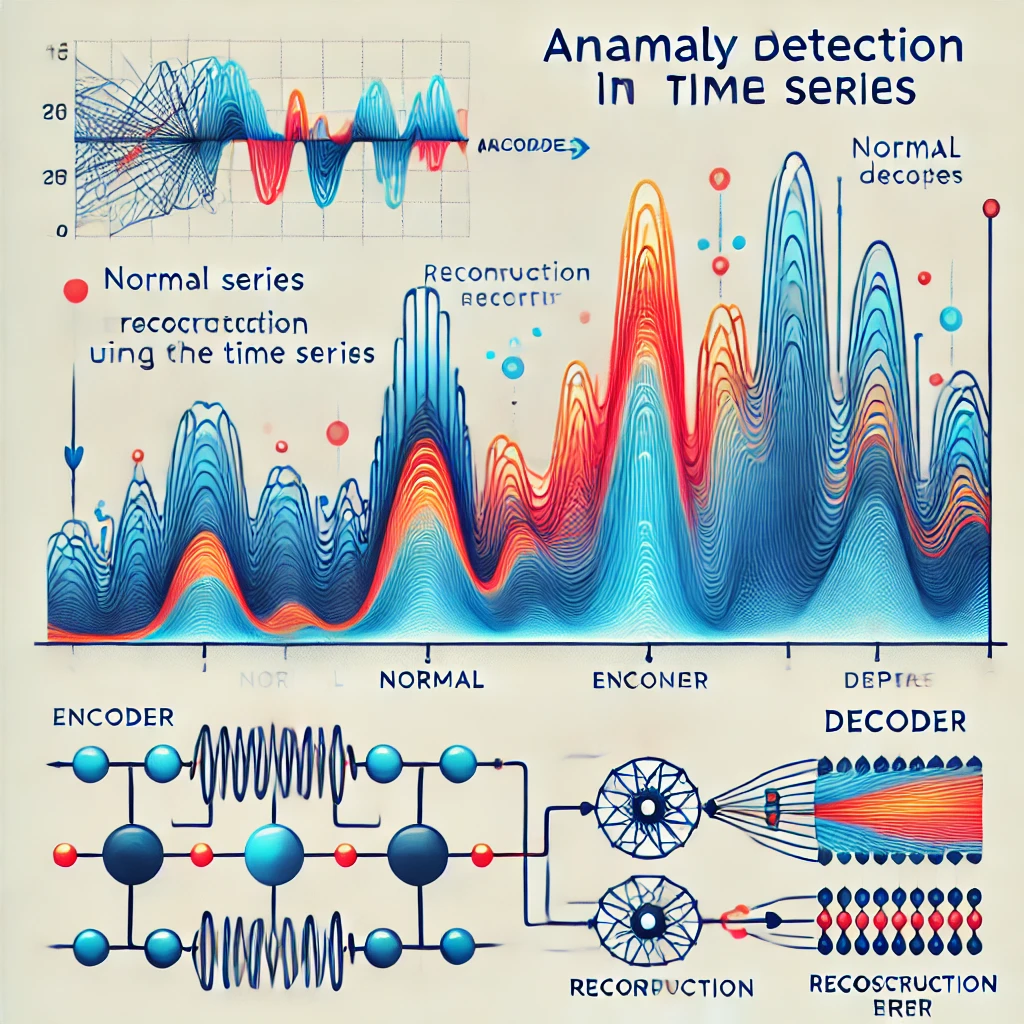

In [7]:
from IPython.display import Image, display, HTML

# HTML to hide code
HTML('''<script>
code_show = false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show or hide the code, click <a href="javascript:code_toggle()">here</a>.''')

# Display the image
image_path = "/Users/disastershubz/Downloads/image.jpg"
display(Image(filename=image_path))




## Introduction

In this script, we build and train a convolutional autoencoder to detect anomalies in time series data. The autoencoder will be trained to reconstruct the normal data, and any significant deviations will be classified as anomalies.

We will use a dataset containing time series data to train the autoencoder to detect these anomalies. The autoencoder is particularly useful in this context because it learns to encode normal behavior, and deviations in its reconstruction can be considered anomalies.
## Setup

First, let's import the necessary libraries that will be used throughout this project.


## Setup

First, let's import the necessary libraries that will be used throughout this project.


In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


## Data Loading and Preprocessing

We will be using a dataset from the Numenta Anomaly Benchmark (NAB), which contains artificially generated time series data with labeled anomalies. The file **art_daily_small_noise.csv** will be used for training (as it contains no anomalies), while **art_daily_jumpsup.csv** will be used for testing (as it includes anomalies).


In [45]:
#url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
train_file =  "/Users/disastershubz/Downloads/archive/artificialNoAnomaly/artificialNoAnomaly/art_daily_small_noise.csv"
test_file =   "/Users/disastershubz/Downloads/archive/artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsup.csv"

# Load the data
train_df = pd.read_csv(train_file, parse_dates=True, index_col="timestamp")
test_df = pd.read_csv(test_file, parse_dates=True, index_col="timestamp")


In [47]:
print(train_data.head())
print(test_data.head())


                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


## Data Visualization

Let’s visualize the time series data to see what it looks like.


<Figure size 1000x600 with 0 Axes>

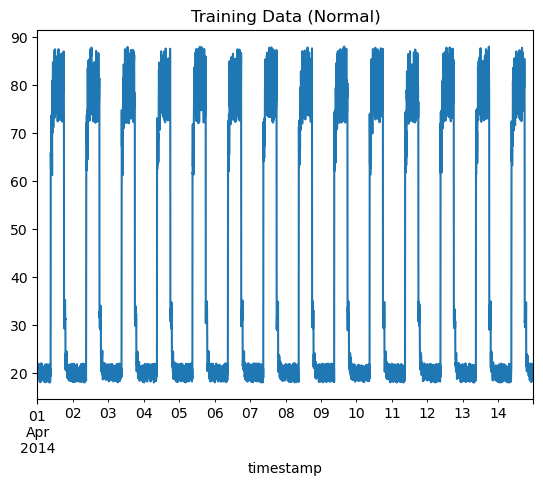

<Figure size 1000x600 with 0 Axes>

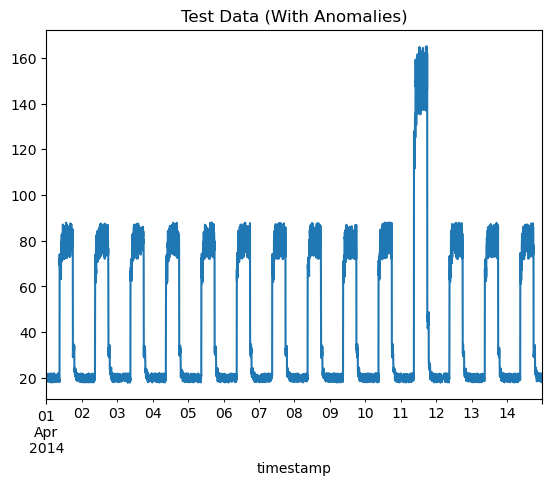

In [49]:

# Visualize the training data
plt.figure(figsize=(10, 6))
train_df.plot(legend=False)
plt.title('Training Data (Normal)')
plt.show()

# Visualize the test data with anomalies
plt.figure(figsize=(10, 6))
test_df.plot(legend=False)
plt.title('Test Data (With Anomalies)')
plt.show()


## Model Building - Autoencoder

We will now build a convolutional autoencoder model. The encoder will compress the time series data, and the decoder will attempt to reconstruct it. Any large deviation between the input and the reconstructed output will be flagged as an anomaly.


In [51]:
# Normalize training data
train_mean = train_df.mean()
train_std = train_df.std()
normalized_train = (train_df - train_mean) / train_std


Next, generate sequences consisting of 288 time steps, which represent a 24-hour period, assuming data is recorded at 5-minute intervals.

In [53]:
# Define sequence length (288 timesteps = 24 hours with 5-minute intervals)
TIME_STEPS = 288

# Create sequences from data
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i: i + time_steps])
    return np.array(sequences)

# Prepare training sequences
x_train = create_sequences(normalized_train.values, TIME_STEPS)
print("Training sequence shape:", x_train.shape)



Training sequence shape: (3744, 288, 1)


## Model Building - Autoencoder

We will now build a convolutional autoencoder model. The encoder will compress the time series data, and the decoder will attempt to reconstruct it. Any large deviation between the input and the reconstructed output will be flagged as an anomaly.


In [55]:
# Build the Convolutional Autoencoder
model = models.Sequential([
    layers.Input(shape=(TIME_STEPS, 1)),
    layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    layers.Dropout(0.2),
    layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    
    layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    layers.Dropout(0.2),
    layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    layers.Conv1D(filters=1, kernel_size=7, padding="same")
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 144, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 144, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 72, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 144, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 288, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 288, 1)         │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Autoencoder

We will split the dataset into training and testing sets, and then train the autoencoder model on the training data.


In [57]:
# Train the autoencoder
history = model.fit(
    x_train, x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]
)



Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7117 - val_loss: 0.0899
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0811 - val_loss: 0.0393
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0583 - val_loss: 0.0373
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0512 - val_loss: 0.0352
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0457 - val_loss: 0.0332
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0414 - val_loss: 0.0327
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0377 - val_loss: 0.0286
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0347 - val_loss: 0.0269
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0323 - val_loss: 0.0284
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0303 - val_loss: 0.0265
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0286 - val_loss: 0.0271
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

## Visualizing the Training Loss

Let’s visualize the training and validation loss to see how well the model is learning.


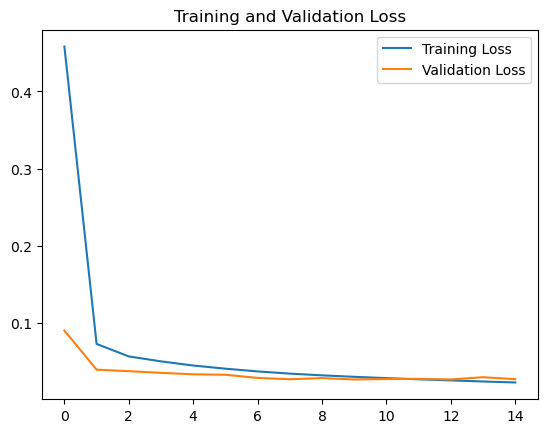

In [59]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



## Anomaly Detection

Now, we will reconstruct the test data and compute the reconstruction error. Any data point with a reconstruction error above a certain threshold will be classified as an anomaly.


# Normalize the test data
normalized_test = (test_df - train_mean) / train_std

# Create test sequences
x_test = create_sequences(normalized_test.values, TIME_STEPS)

# Get reconstruction error on test data
test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(test_pred - x_test), axis=1)


Evaluating on Anomaly Data  
Start by normalizing the test data and creating sequences.

In [61]:
# Get reconstruction error on training data
train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(train_pred - x_train), axis=1)

# Set threshold based on max reconstruction error from training data
threshold = np.max(train_mae_loss)
print(f"Reconstruction error threshold: {threshold}")



117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction error threshold: 0.12621706166862923


In [65]:
# Flag anomalies
anomalies = test_mae_loss > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")



Number of anomalies detected: 401


**visualize the anamolies**

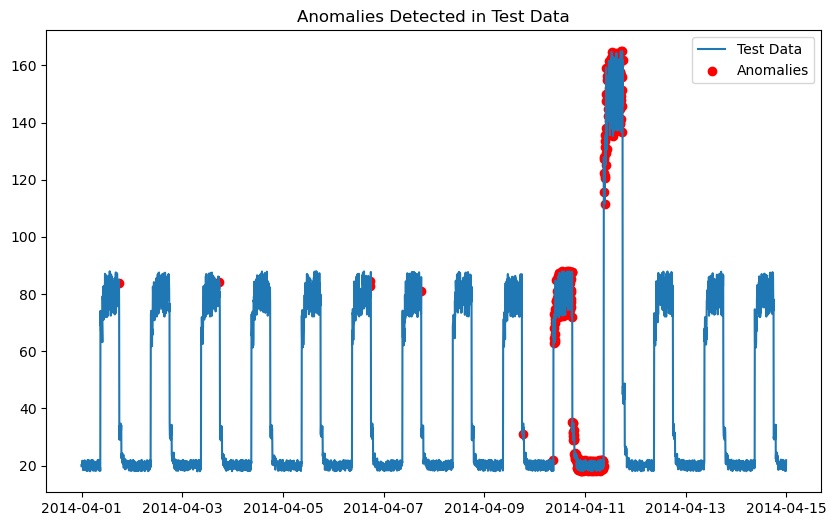

In [95]:
# Plot anomalies
anomalous_indices = np.where(anomalies)[0]
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df['value'], label='Test Data')
plt.scatter(test_df.iloc[anomalous_indices].index, test_df.iloc[anomalous_indices]['value'], color='red', label='Anomalies')
plt.legend()
plt.title('Anomalies Detected in Test Data')
plt.show()
